# Worker Analysis Notebook

The aim of this notebook is to ingest, analysis and prepare the worker data, ready for clustering. 

The data for this notebook comes from the `dataset_worker`. 

This data can be found in the `s3://skillsforcare/emr-notebooks/csvFiles/workerFull` folder. 

Alternatively, you can generate this data using the following code snippet in an EMR PySpark notebook:

```
spark.sql("use data_engineering_glue_db")

df = spark.sql("""
select 
    *
from 
    dataset_worker
where 
    import_date = '20220318'
    
""")

df.write.option("header","true").csv("s3://skillsforcare/emr-notebooks/csvFiles/workerFull")
```

The resulting files can then be found in the directory shown above.

In [138]:
import pandas as pd
import numpy as np
import missingno as msno

In [139]:
load_1 = pd.read_csv("../Data/worker_analysis/2022/full_worker_1.csv")
load_2 = pd.read_csv("../Data/worker_analysis/2022/full_worker_2.csv")
load_3 = pd.read_csv("../Data/worker_analysis/2022/full_worker_3.csv")

/var/folders/vb/1h_w_7ns5y33k3p9zslr_3cw0000gq/T/ipykernel_32295/587050753.py:1: DtypeWarning: Columns (362,374,410,416,446,452,488,494,500,506,512,518,524,530,536,542,548,554,560,566,572,578,632,636) have mixed types. Specify dtype option on import or set low_memory=False.
  load_1 = pd.read_csv("../Data/worker_analysis/2022/full_worker_1.csv")
/var/folders/vb/1h_w_7ns5y33k3p9zslr_3cw0000gq/T/ipykernel_32295/587050753.py:2: DtypeWarning: Columns (15,16,63,362,368,374,380,386,392,398,404,410,416,422,428,434,440,446,452,458,464,470,476,482,488,494,500,506,512,518,524,530,536,542,548,554,560,566,572,578,595,601,603,605,606,609,610,629,630,631,632,636,661,662,663,664,666,667) have mixed types. Specify dtype option on import or set low_memory=False.
  load_2 = pd.read_csv("../Data/worker_analysis/2022/full_worker_2.csv")
/var/folders/vb/1h_w_7ns5y33k3p9zslr_3cw0000gq/T/ipykernel_32295/587050753.py:3: DtypeWarning: Columns (15,362,368,374,380,386,392,398,404,410,416,422,428,434,440,446,452,

In [140]:
## Concaternate the loaded csv files into a single data frame
df = pd.concat([load_1, load_2, load_3]).drop("lauthid", axis=1)
print(df.shape)

(735270, 675)


In [141]:
for c in df.columns:
    print(c)

period
establishmentid
tribalid
tribalid_worker
parentid
orgid
nmdsid
workerid
wrkglbid
wkplacestat
createddate
updateddate
cqcpermission
lapermission
regtype
providerid
locationid
esttype
regionid
cssr
mainstid
emplstat
mainjrid
strtdate
age
gender
disabled
ethnicity
isbritish
nationality
britishcitizen
borninuk
countryofbirth
yearofentry
homeregionid
homecssrid
homelauthid
homeparliamentaryconstituency
distwrkk
scerec
startsec
startage
dayssick
dayssick_changedate
zerohours
averagehours
averagehours_changedate
averagehours_savedate
conthrs
conthrs_changedate
salaryint
salary
hrlyrate
pay_changedate
ccstatus
ccstatus_changedate
apprentice
scqheld
levelscqheld
nonscqheld
levelnonscqheld
listqualsachflag
listqualsachflag_changedate
listhiqualev
jr01flag
jr02flag
jr03flag
jr04flag
jr05flag
jr06flag
jr07flag
jr08flag
jr09flag
jr10flag
jr11flag
jr15flag
jr16flag
jr17flag
jr22flag
jr23flag
jr24flag
jr25flag
jr26flag
jr27flag
jr34flag
jr35flag
jr36flag
jr37flag
jr38flag
jr39flag
jr40flag
jr4

### The following cell contains dictionaries used to transform column data into a more readable state

In [142]:
## Employment Status
emplDict = {-1: None, 190: "Permanent",191: "Temporary",192: "Bank or pool", 193: "Agency",194: "Student",196: "Other"}

## Salary int
salaryDict = {-2:None, -1:None, 250:"Annual", 251:"251", 252:"Hourly", 253:"253"}

## Disability 
disDict = {-2:None,-1:None,0:"No",1:"Yes",2:None,}

## Gender
genderDict = {-1:None, 1:"Male", 2:"Female", 3:None, 4:"Other"}

## Sector of the workplace
esttypeDict = {
    -1: None,
    1:"Local authority (adult services)", 
    3:"Local authority (generic/other)", 
    6:"Private sector", 
    7:"Voluntary/charity", 
    8:"Other"
}

# Main service provided
mainstidDict = {
    1:"Care home services with nursing - CQC Regulated", 2:"Care home services without nursing - CQC Regulated", 
    5:"Other adult residential care service", 6:"Day care and day services", 7:"Other adult day care services",
    8:"Domiciliary Care services - CQC Regulated", 10:"Domestic services and home help",  12:"Other adult domiciliary care services", 
    13:"Carers support", 14:"Short breaks or respite care", 15:"Community support and outreach", 16:"Social work and care management", 
    17:"Shared lives - CQC Regulated", 18:"Disability adaptations or assistive technology services", 
    19:"Occupational or employment related services", 20:"Information and advice services", 
    21:"Other adult community care services", 52:"Any Other Services", 53:"Sheltered housing", 
    54:"Extra Care housing services - CQC Regulated", 55:"Supported living services - CQC Regulated", 
    60:"Specialist College Services - SPC", 61:"Community based services for people with a learning disability - CQC Regulated", 
    62:"Community based services for people with mental health needs - CQC Regulated", 
    63:"Community based services for people who misuse substances - CQC Regulated", 64:"Community healthcare services - CQC Regulated",
    66:"Hospice services - CQC Regulated", 67:"Long Term conditions services - CQC Regulated", 
    68:"Hospital services for people with mental health needs and/or learning disabilities and/or problems with substance misuse - CQC Regulated", 
    69:"Rehabilitation services - CQC Regulated", 70:"Residential substance misuse treatment/rehabilitation services - CQC Regulated", 
    71:"Other healthcare service", 72:"Head Office Services"
}

## Zero hours
zeroDict = {-2:None, -1:None, 0:"No", 1:"Yes"}

## Qualification
qualHeldDict = {-1:None, 1:"Yes", 2:"No", 3:None}

## Training 
trainDict = {0:"No", 1:"Yes"}

## Apprenticeships
aprenDict = {-1: None,1: "Yes",2: "No",3: None}

## Qualification level 
qualDict = {
    -2:"N/A",-1:None,0:"Entry",1:"Level 1",2:"Level 2",3:"Level 3",4:"Level 4",5:"Level 5",
    6:"Level 6",7:"Level 7",8:"Level 8 or above",10:None
}

# Ethnicity 
ethDict = {
    -1:None ,31:"White British",32:"Irish", 33:"Gypsy or Irish Traveler",34:"Any Other White background", 35:"White and Black Caribbean", 
    36:"White and Black African",37:"White and Asian", 38:"Mixed",39:"Indian", 40:"Pakistani", 41:"Bangladeshi", 42:"Chinese", 
    43:"Other - Asian", 44:"African", 45:"Caribbean", 46:"Other - Black", 47:"Arab", 98:"Other", 99:None
}

## Jobs
jobDict = {
    1:"Senior Management",2:"Middle Management",3:"First Line Manager",4:"Registered Manager", 5:"Supervisor",6:"Social Worker",
    7:"Senior Care Worker",8:"Care Worker",9:"Community Support and Outreach Work",10:"Employment Support",11:"Advice Guidance and Advocacy",
    15:"Occupational Therapist",16:"Registered Nurse",17:"Allied Health Professional",22:"Technician",23:"Other care-providing job role",
    24:"Managers and staff in care-related but not care-providing roles",25:"Administrative or office staff not care-providing",
    26:"Ancillary staff not care-providing",27:"Other non-care-providing job roles",34:"Activities worker or co-ordinator",
    35:"Safeguarding and reviewing officer",36:"Occupational therapist assistant",37:"Nursing Associate",38:"Nursing Assistant",
    39:"Assessment officer",40:"Care co-ordinator",41:"Care navigator",42:"Any Childrens/young peoples job role"
}

## Job group
jobGroupDict = {
    "Manager/Supervisor":[1, 2, 3, 4, 5, 24],
    "Professional":[6, 15, 16, 17, 35, 37],
    "Direct Care":[7, 8, 9, 10, 11, 22, 23, 38],
    "Other":[25, 26, 27, 34, 36, 39, 40, 41, 42]
}

## Recruitment
recDict = {
    -1:None, 210:"ACS: Local Authority", 211:"ACS: Private/Voluntary", 214:"Health sector", 216:"Other sector", 217:"Promotion / Transfer / Development", 
    219:"Not previously employed", 221:"Agency", 224:"Other sources", 225:None, 226:"Children's/young people's social care", 227:"First role after education",
}

### The ingested data has already been hot encoded. For the purpose of cleaning and quality checking, we first need to un-encode the columns we wish to include. 

In [143]:
def get_encoding(row, col_list):
    '''
    This function scans through each column in a list and returns the column name for
    the first instance where that column equals 1. If there is no 1 present in the row 
    then None is returned. 
    '''
    for c in col_list:
        if row[c]==1:
            return c

In [144]:
## Scan through the "ut" columns - indicating the type of people a worker cares for.

ut_scan = [
    "workerid", "ut01flag","ut02flag","ut22flag","ut23flag","ut25flag","ut26flag","ut27flag","ut46flag","ut03flag","ut04flag","ut05flag",
    "ut06flag","ut07flag","ut08flag","ut28flag","ut29flag","ut31flag","ut09flag","ut18flag","ut19flag","ut20flag","ut45flag",
    "ut21flag"
]

ut_df = df[ut_scan].copy()
ut_scan.remove("workerid")
ut_df["people_cared_for"] = ut_df.apply(lambda x: get_encoding(x, ut_scan), axis=1)

In [145]:
## Scan through the "training" columns - indicating the level of training a worker has received

train_scan = [
    "workerid", "tr01flag","tr02flag","tr05flag","tr06flag","tr07flag","tr08flag","tr09flag","tr10flag","tr11flag","tr12flag","tr13flag","tr14flag",
    "tr15flag","tr16flag","tr17flag","tr18flag","tr19flag","tr20flag","tr21flag","tr22flag","tr23flag","tr25flag","tr26flag","tr27flag",
    "tr28flag","tr29flag","tr30flag","tr31flag","tr32flag","tr33flag","tr34flag","tr35flag","tr36flag","tr37flag","tr38flag","tr39flag",
    "tr40flag"
]

train_df = df[train_scan].copy()
train_scan.remove("workerid")
train_df["training"] = train_df.apply(lambda x: get_encoding(x, train_scan), axis=1)

In [146]:
## Add these columns back onto the main df

df = df.merge(ut_df[["workerid", "people_cared_for"]], on="workerid", how="outer")
df = df.merge(train_df[["workerid", "training"]], on="workerid", how="outer")

### Many of the columns in the initial upload are supurfulus and cannot be used at this stage to train a classification model. We therefore cut this down to an initial set of 31 features. 

In [147]:
df_core = df[
    [
        "establishmentid","workerid","esttype","cssr","mainjrid","mainstid","emplstat","strtdate",
        "age","gender","disabled","ethnicity","nationality","distwrkk","scerec","startsec","startage",
        "dayssick","zerohours","averagehours","conthrs","salaryint","salary","hrlyrate","apprentice",
        "scqheld","levelscqheld","trainflag","people_cared_for","training",
    ]
]
print(df_core.shape)
df_core.isnull().sum()

(735270, 30)


establishmentid          0
workerid                 0
esttype               2160
cssr                     0
mainjrid                 0
mainstid               568
emplstat                 0
strtdate             35040
age                  35253
gender                   0
disabled                 0
ethnicity                0
nationality              0
distwrkk            143567
scerec                   0
startsec                 0
startage              3104
dayssick                 0
zerohours                0
averagehours             0
conthrs                  0
salaryint                0
salary              544835
hrlyrate            274379
apprentice               0
scqheld                  0
levelscqheld             0
trainflag                0
people_cared_for     22500
training            499499
dtype: int64

In [148]:
# First, we go through the data and apply the predefined dictionary values to their respective columns. 

df_core = df_core.replace(
    {"gender": genderDict}
).replace(
    {"ethnicity": ethDict}
).replace(
    {"mainstid": mainstidDict}
).replace(
    {"zerohours": zeroDict}
).replace(
    {"esttype": esttypeDict}
).replace(
    {"trainflag": trainDict}
).replace(
    {"scqheld": qualHeldDict}
).replace(
    {"levelscqheld": qualDict}
).replace(
    {"disabled": disDict}
).replace(
    {"emplstat": emplDict}
).replace(
    {"scerec": recDict}
).replace(
    {"apprentice": aprenDict}
)

In [149]:
# Replace values with "None" where appropriate. 

df_core = df_core.replace(-1, None)
df_core = df_core.replace(-2, None)
df_core = df_core.replace("", None)

In [150]:
# Rename columns to make the data easier to work with

df_core = df_core.rename(
    columns={
        "establishmentid":"est_id",
        "workerid"       :"worker_id",
        "esttype"        :"est_type",
        "cssr"           :"cssr",
        "mainstid"       :"service_provide",
        "emplstat"       :"emp_status",
        "strtdate"       :"start_cur_role_date",
        "age"            :"age",
        "gender"         :"gender",
        "disabled"       :"disabled",
        "ethnicity"      :"ethnicity",
        "nationality"    :"nationality",
        "distwrkk"       :"dist_mi",
        "scerec"         :"recruitment",
        "startsec"       :"yrs_in_asc",
        "startage"       :"start_age",
        "dayssick"       :"days_sick",
        "zerohours"      :"zero_hr_cont",
        "averagehours"   :"avg_hrs",
        "conthrs"        :"cont_hrs",
        "salaryint"      :"salary_int",
        "salary"         :"salary",
        "hrlyrate"       :"hr_rate",
        "apprentice"     :"apprentice",
        "scqheld"        :"asc_qul_held",
        "version"        :"version",
        "ut"             :"care_type",
        "training"       :"training",
    }
)

In [151]:
## Split the mainjrid column into two separate columns. 

def get_keys_from_value(d, val):
    '''
    Use a dictionary item to return the associated key 
    '''
    return [k for k, v in d.items() if val in v][0]

    

df_core["main_job"] = df_core["mainjrid"].apply(lambda x: jobDict[x])
df_core["job_group"] = df_core["mainjrid"].apply(lambda x: get_keys_from_value(jobGroupDict, x))
df_core = df_core.drop(["mainjrid"], axis=1)

### At this stage, we can use the Missingno library to generate a snapshot of the data. Here, white space indicates regions of the data set that contain "None" data. 

<AxesSubplot:>

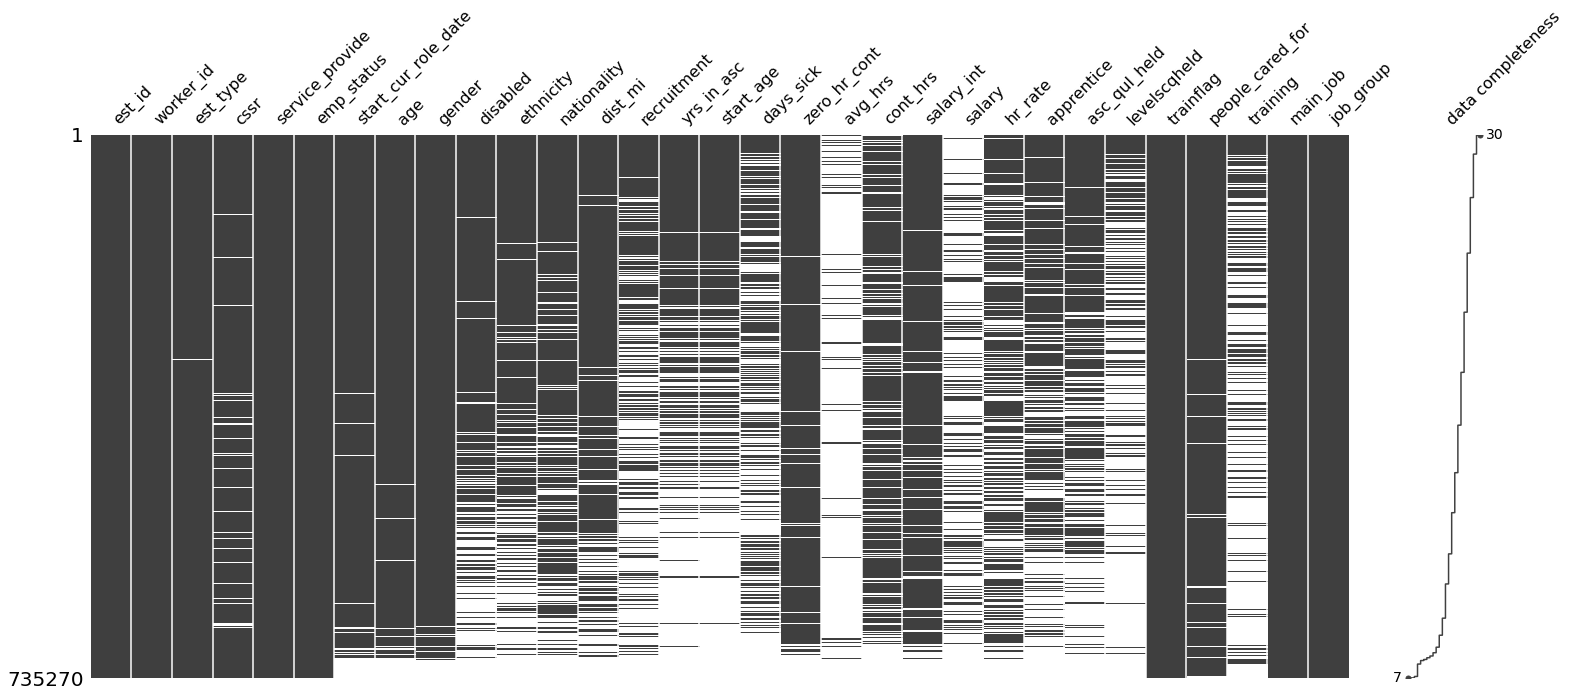

In [152]:
msno.matrix(df_core, labels=True, sort="descending")

### Machine learning cannot deal with Null/None values. In order to train models we need to distill this dataset down a version that has zero Nulls. 

In [153]:
## We begin by droping rows with None for age, nationality, cssr, start_age, est_type, service_provide, start_cur_role_date, gender, ethnicity, 
## disabled, dist_mi, nationality, as with this data set, we have no way presently of inferring or deducing these values. 

df_core = df_core.dropna(
    subset = [
        "age", "gender", "ethnicity", "disabled", "dist_mi", "nationality", 
        "cssr", "start_age", "est_type", "service_provide", "start_cur_role_date"
    ],
    axis=0
).reset_index(drop=True)

### We know that workers can either be salaried or work under a zero hours contract. Looking at the graph above, we can also see that both salary and hr_rate have missing values, although these seem to correlate with each other. 

### The next step in this cleaning process will be to convert salaries into hourly rates, with the goal of creating a single column including as many rows as possible. 

In [154]:
def hours_worked(df_row):
    '''
    This function takes a row of data and applies a series of logical steps to return
    a value for the number of hours worked by an employee. 
    '''
    cHrs = df_row.cont_hrs
    aHrs = df_row.avg_hrs

    if cHrs in [None, -1, -2] or cHrs > 100:
            cHrs = None

    if aHrs in [None, -1, -2] or aHrs > 100:
            aHrs = None

    # Role is perm or temp
    if df_row.emp_status in ["Permanent", "Temporary"]:
        # role is zero hr
        if df_row.zero_hr_cont == "Yes":
            if not aHrs:
                if not cHrs:
                    return cHrs
                return aHrs
            return aHrs
        # role is NOT zero hr
        if df_row.zero_hr_cont != "Yes":
            if not cHrs:
                if not aHrs:
                    return aHrs
                return cHrs
            return cHrs
    # If role not perm or temp
    else:
        if not aHrs:
            if not cHrs:
                return cHrs
            return aHrs
        return aHrs


def hourly_pay(row):
    '''
    Calculate the hourly pay of an employee using either the hours worked and salary
    values or simply the provided hourly rate
    '''
    if row.salary_int == 250:
        if pd.isna(row.salary):
            return None
        try:
            return np.round((row.salary / 52 / row.hrs_worked), 2)
        except:
            return None
    if row.salary_int == 252:
        return row.hr_rate

In [155]:
## We will start by isolating a select number of columns and storing them in a new data set. 
hours_df = df_core[["worker_id", "emp_status", "zero_hr_cont", "avg_hrs", "cont_hrs", "salary", "salary_int", "hr_rate"]].copy()

## Here we calculate the hours worked for each employee
hours_df["hrs_worked"] = hours_df.apply(lambda x: hours_worked(x), axis=1)

## Next we use either the hours worked or provided value to populate a new calc_hrs_worked column
hours_df["calc_hr_rate"] = hours_df.apply(lambda x: hourly_pay(x), axis=1)

In [156]:
## Merge these two calculated rows back into the core data frame. 
df_core = df_core.merge(hours_df[["worker_id", "hrs_worked", "calc_hr_rate"]], on="worker_id")

## Dop the now superfluous columns, followed by dropping rows with still no hourly rate associated with them, making sure to reset the index.
df_core = df_core.drop(["avg_hrs", "cont_hrs", "salary", "hr_rate"], axis=1).dropna(subset=["hrs_worked", "calc_hr_rate"], axis=0).reset_index(drop=True)

<AxesSubplot:>

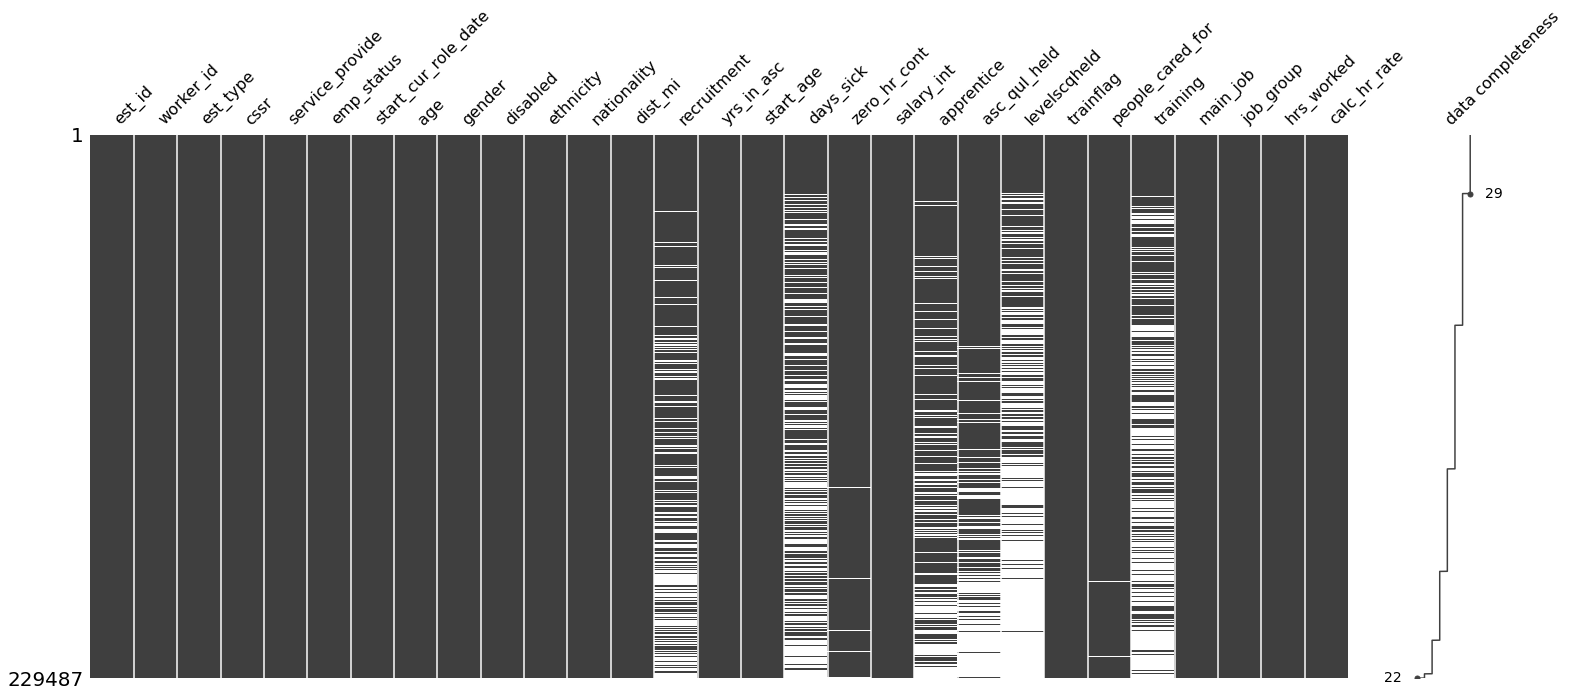

In [157]:
msno.matrix(df_core, labels=True, sort="descending")

### With these two steps we can see that we have already improved the quality of our data set. We should also note that we have gone from 735,270 entries down to 230,025 entries. So although the quality has increased the size of the set has decreased significantly. This is still a large data set, so this is not something we have to be concerned about yet, but we have to be aware of the reduction. 

### The next block we will tackle is training and qualifications. 

In [158]:
## Again, we start by isolating a select number of columns and storing them in a new data set. 
df_qual = df_core[["worker_id", "asc_qul_held", "levelscqheld", "trainflag", "training", "apprentice"]].copy()

In [159]:
## We can see here that there are ~53,000 rows there the employee has not provided information about weather they hold qualifications.
df_qual["asc_qul_held"].value_counts(dropna=False)

Yes     101966
No       74440
None     53081
Name: asc_qul_held, dtype: int64

In [160]:
## Under closer inspection we find a number of instances where the employee has stated they hold no qualifications and then have provided a qualification. 
## We will drop these rows as there a relatively few and we cannot be confident in the information they are providing. 
df_qual = df_qual.drop(
    df_qual[["asc_qul_held","levelscqheld"]][np.logical_and(df_qual["asc_qul_held"] == "No", pd.notnull(df_qual["levelscqheld"]))].index
).reset_index(drop=True)

In [161]:
# Drop rows with None values for asc_qul_held
df_qual = df_qual.dropna(subset=["asc_qul_held"]).reset_index(drop=True)

In [162]:
## We want to capture when employees state No qualifications held, so we provide a non None value. 
df_qual["levelscqheld"] = df_qual.apply(lambda x: "No qual" if x.asc_qul_held == "No" else x.levelscqheld , axis=1)

#### We see that there are still None values in the `levelscqheld` column - indicating instances of employees stating that they do hold qualifications but then not providing to what level. Given we require highly reliable and clean data, we remove these instances. 

In [163]:
df_qual.levelscqheld.value_counts(dropna=False)

No qual             74417
Level 2             41009
Level 3             35347
Level 4              5843
Level 5              5646
None                 4753
Level 6              3921
Entry                2604
Level 1              1629
Level 7               797
Level 8 or above      417
Name: levelscqheld, dtype: int64

In [164]:
df_qual = df_qual.dropna(subset=["levelscqheld"]).reset_index(drop=True)

#### We now look at the training columns 

In [165]:
df_qual["trainflag"].value_counts(dropna=False)

Yes    91603
No     80027
Name: trainflag, dtype: int64

In [166]:
df_qual[pd.isnull(df_qual["training"])].shape[0]

80027

#### We can see that we have the same number of None values in the training column as "No" values in the training flag column. We again want to capture the instances of "No" so fill the None values with "No training".

In [167]:
df_qual["training"] = df_qual["training"].fillna("tr00flag")

#### Finally, we can inspect the apprentice column.

In [168]:
df_qual["apprentice"].value_counts(dropna=False)

No      139913
None     26115
Yes       5602
Name: apprentice, dtype: int64

#### As we are unable to infer or otherwise determine weather or not an employee is an apprentice, we are forced to drop None value rows from the data set.

In [169]:
df_qual = df_qual.dropna(subset=["apprentice"]).reset_index(drop=True)
df_qual.shape[0]

145515

#### This has left us with 145,515 rows of complete data. We can now merge these back with our core dataset. 

In [170]:
df_core = df_core.drop(columns=["asc_qul_held", "levelscqheld", "trainflag", "training", "apprentice"], axis=1)

In [171]:
## Merge these two calculated rows back into the core data frame. 
df_core = df_core.merge(df_qual, on="worker_id", how="outer")

## Dop the now superfluous columns, followed by dropping rows with still no hourly rate associated with them, making sure to reset the index.
df_core = df_core.dropna(subset=["levelscqheld"], axis=0).reset_index(drop=True)

#### Let us take a look at the progress we have made in cleaning the data.

<AxesSubplot:>

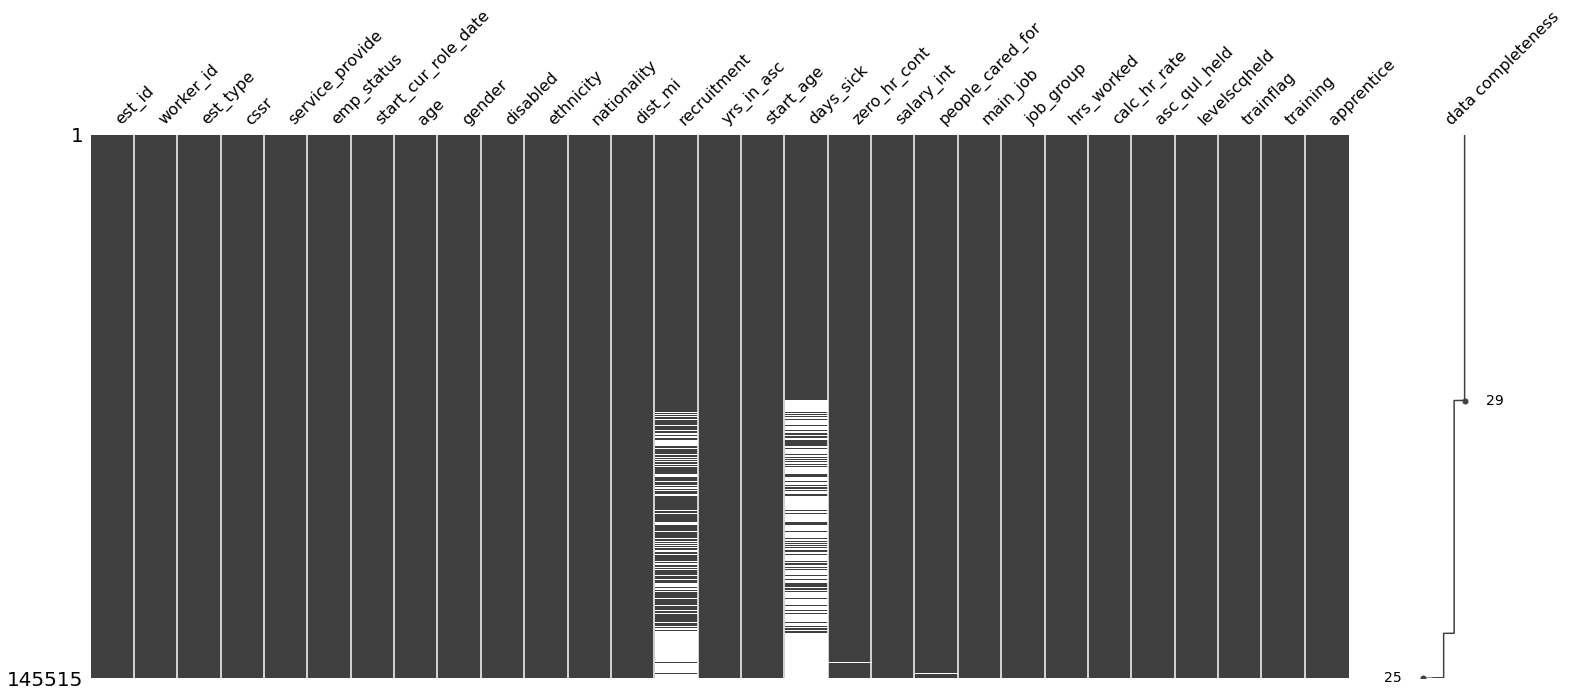

In [172]:
msno.matrix(df_core, labels=True, sort="descending")

#### Next we will tackle sick days, as we have some existing logic that should be applied. 

#### Business knowledge tells us that, in some instances, organisations will simply upload .csv files of worker details. In these instances, it is not uncommon for data to simply be copied and pasted across multiple workers, creating sets of highly unreliable data. 

#### To combat this practice, we will identify establishments with more than 15 employees that all claim to have taken zero sick days in the past year. 

In [173]:
## Identify establishments with more than 15 entries
## Check if all sick day entries are equal to 0
data_mask = df_core.loc[df_core.groupby("est_id")["est_id"].transform("count") > 15].groupby(df_core.est_id).days_sick.sum().eq(0)

In [174]:
## Make a data series for establishment IDs where the number of data entries is greater than 10 and all values have been entered as 0
data_mask = data_mask.reset_index()
est_ids_remove = data_mask.loc[data_mask.days_sick == True]["est_id"]

In [175]:
## remove est_id identified above from the core data set
df_core = df_core.loc[~df_core.est_id.isin(est_ids_remove)]
df_core.shape

(117743, 29)

#### Finally, given we are unable to glean any more information, we simply discard rows where no information is provided. 

In [176]:
df_core = df_core.dropna(subset=["days_sick"], axis="index").reset_index(drop=True)

<AxesSubplot:>

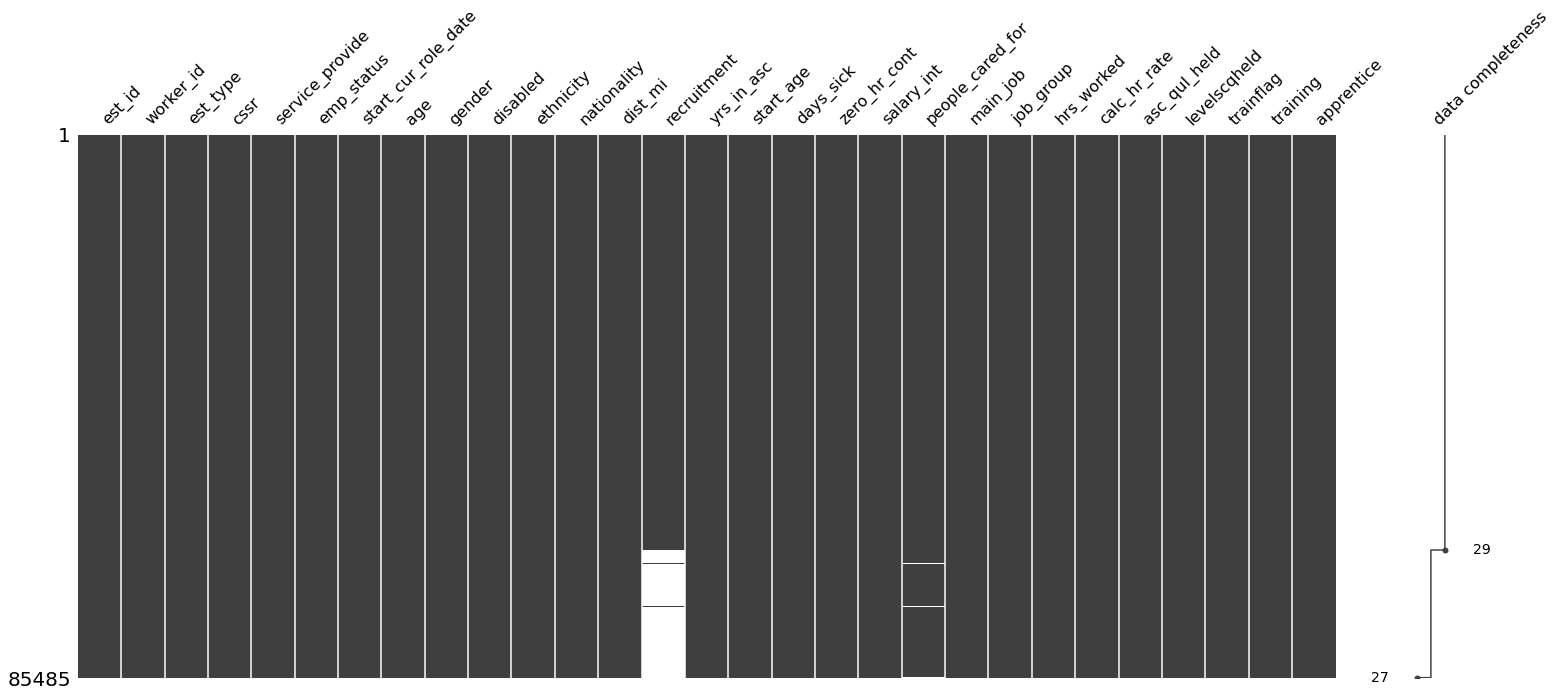

In [177]:
msno.matrix(df_core, labels=True, sort="descending")

#### The final data set to tackle is the recruitment column.

In [178]:
df_core.recruitment.value_counts(dropna=False)

ACS: Private/Voluntary                   27261
None                                     19784
Other sources                            10671
ACS: Local Authority                      8866
Other sector                              8574
Health sector                             3467
Not previously employed                   2163
Promotion / Transfer / Development        2096
Agency                                    1129
Children's/young people's social care     1013
First role after education                 461
Name: recruitment, dtype: int64

#### Again, we can do little more than drop these rows, given there is no way for us to otherwise discern the information. 

In [179]:
df_core = df_core.dropna(axis=0)

<AxesSubplot:>

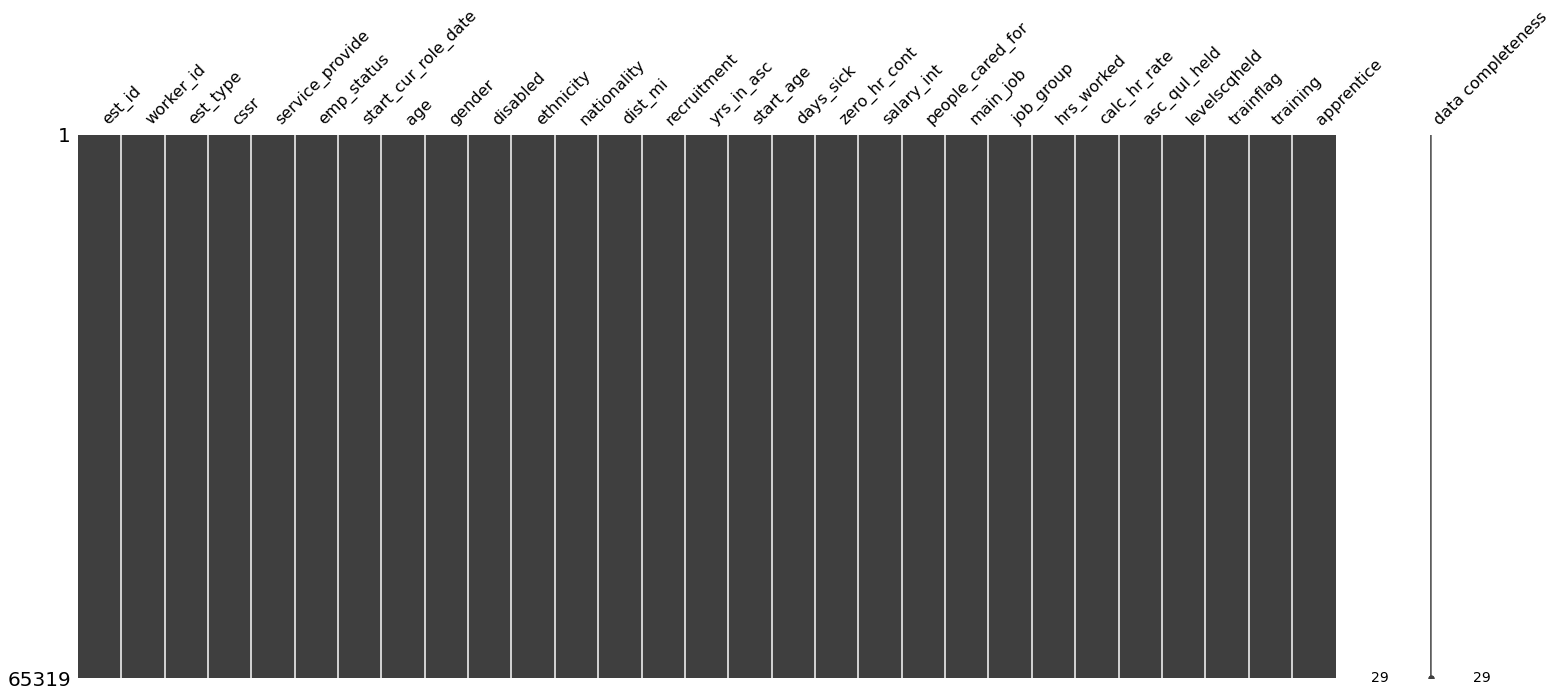

In [180]:
msno.matrix(df_core, labels=True, sort="descending")

In [181]:
df_core.isnull().sum()

est_id                 0
worker_id              0
est_type               0
cssr                   0
service_provide        0
emp_status             0
start_cur_role_date    0
age                    0
gender                 0
disabled               0
ethnicity              0
nationality            0
dist_mi                0
recruitment            0
yrs_in_asc             0
start_age              0
days_sick              0
zero_hr_cont           0
salary_int             0
people_cared_for       0
main_job               0
job_group              0
hrs_worked             0
calc_hr_rate           0
asc_qul_held           0
levelscqheld           0
trainflag              0
training               0
apprentice             0
dtype: int64

#### Now that we have generated a clean data set with all the required columns of information we can save this as a .cvs and start a new notebook focussing on sense checking the data.

In [182]:
df_core.to_csv("../Data/worker_analysis/complete_worker.csv", index=False)